In [1]:
from glob import glob

import pandas as pd
from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars, extractor
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import describe
from thefuzz import fuzz


In [52]:
save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/grad_analysis'

norms = pd.DataFrame(io.load_json(f)['param2norm_diff'] for f in glob(f'{save_dir}/*.json', recursive=True))

In [11]:
import yaml 

target_modules = yaml.safe_load(open("../config/model/llama3.2-1B-eos-sft.yaml", "r"))["inner_params"]

In [4]:
target_modules

['model.layers.13.mlp.gate_proj.weight',
 'model.layers.13.mlp.up_proj.weight',
 'model.layers.13.mlp.down_proj.weight',
 'model.layers.14.mlp.gate_proj.weight',
 'model.layers.14.mlp.up_proj.weight',
 'model.layers.14.mlp.down_proj.weight',
 'model.layers.15.mlp.gate_proj.weight',
 'model.layers.15.mlp.up_proj.weight',
 'model.layers.15.mlp.down_proj.weight']

In [5]:
mean_norms = norms.mean().to_dict()

In [6]:
mean_norms

{'model.embed_tokens.weight': 0.18116412371397017,
 'model.layers.0.self_attn.q_proj.weight': 0.04541116964071989,
 'model.layers.0.self_attn.k_proj.weight': 0.023152578007429838,
 'model.layers.0.self_attn.v_proj.weight': 0.023211287334561348,
 'model.layers.0.self_attn.o_proj.weight': 0.046446634121239186,
 'model.layers.0.mlp.gate_proj.weight': 0.09225959986448289,
 'model.layers.0.mlp.up_proj.weight': 0.09222939878702163,
 'model.layers.0.mlp.down_proj.weight': 0.09236382424831391,
 'model.layers.0.input_layernorm.weight': 0.001017067030770704,
 'model.layers.0.post_attention_layernorm.weight': 0.001018687748000957,
 'model.layers.1.self_attn.q_proj.weight': 0.04648720983415842,
 'model.layers.1.self_attn.k_proj.weight': 0.023182088155299426,
 'model.layers.1.self_attn.v_proj.weight': 0.023211745377629996,
 'model.layers.1.self_attn.o_proj.weight': 0.04675702504813671,
 'model.layers.1.mlp.gate_proj.weight': 0.09230813145637512,
 'model.layers.1.mlp.up_proj.weight': 0.0922359066456

In [7]:
sorted(mean_norms.items(), key=lambda x: x[1], reverse=True)

[('model.embed_tokens.weight', 0.18116412371397017),
 ('model.layers.15.mlp.down_proj.weight', 0.11175272859632969),
 ('model.layers.15.mlp.gate_proj.weight', 0.11043057136237622),
 ('model.layers.15.mlp.up_proj.weight', 0.11026134446263314),
 ('model.layers.14.mlp.down_proj.weight', 0.1076788592338562),
 ('model.layers.14.mlp.up_proj.weight', 0.1069567572325468),
 ('model.layers.14.mlp.gate_proj.weight', 0.10674371100962161),
 ('model.layers.13.mlp.down_proj.weight', 0.10564491972327232),
 ('model.layers.13.mlp.up_proj.weight', 0.1051783037930727),
 ('model.layers.13.mlp.gate_proj.weight', 0.10499214604496956),
 ('model.layers.11.mlp.down_proj.weight', 0.10436434872448444),
 ('model.layers.12.mlp.down_proj.weight', 0.10432751476764679),
 ('model.layers.11.mlp.up_proj.weight', 0.10419705659151077),
 ('model.layers.12.mlp.up_proj.weight', 0.10403478547930717),
 ('model.layers.10.mlp.down_proj.weight', 0.10363420963287354),
 ('model.layers.12.mlp.gate_proj.weight', 0.10362224385142327),


In [28]:
non_transformer_block_ks = [k for k in mean_norms.keys() if "layers" not in k]

print("norm from non-transformer blocks:", round(sum(mean_norms[k] for k in non_transformer_block_ks) / sum(mean_norms.values()) * 100, 1), "%\n")

print("Norm from transformer blocks:")
mlp_or_attn_ks = [k for k in mean_norms.keys() if "layers" in k and ("mlp" in k or "self_attn" in k)]
print("norm from mlp or attn:", round(sum(mean_norms[k] for k in mlp_or_attn_ks) / sum(mean_norms.values()) * 100, 1), "%")

non_mlp_or_attn_ks = [k for k in mean_norms.keys() if "layers" in k and not ("mlp" in k or "self_attn" in k)]
print("norm from neither mlp nor attn:", round(sum(mean_norms[k] for k in non_mlp_or_attn_ks) / sum(mean_norms.values()) * 100, 1), "%")

norm from non-transformer blocks: 2.5 %

Norm from transformer blocks:
norm from mlp or attn: 97.1 %
norm from neither mlp nor attn: 0.5 %


# Plot the norm across layer and by module

In [ ]:
from collections import defaultdict
# accumulate norms for each layer by mlp or self_attn
df_content = []

for instance_norm in norms.to_dict("records"):
    total_instance_norms = sum(instance_norm.values())
    norm_lookup = defaultdict(float)

    for k, v in instance_norm.items():
        
        if f"layers." in k:
            l = k.split(".")[2]
            assert l.isdigit()
            l = int(l)
            
            module = k.split(".")[3]
            if module in ["mlp", "self_attn"]:
                norm_lookup[(l, module)] += v
            else:
                continue
        else:
            assert k in non_transformer_block_ks
            continue
        
    norm_lookup = {k: v / total_instance_norms * 100 for k, v in norm_lookup.items()}
    

    for (l, module), percentage in norm_lookup.items():
        df_content.append({"layer": l, "module": module, "Norm(%)": percentage})
    df = pd.DataFrame(df_content)

<Axes: xlabel='layer', ylabel='Norm(%)'>

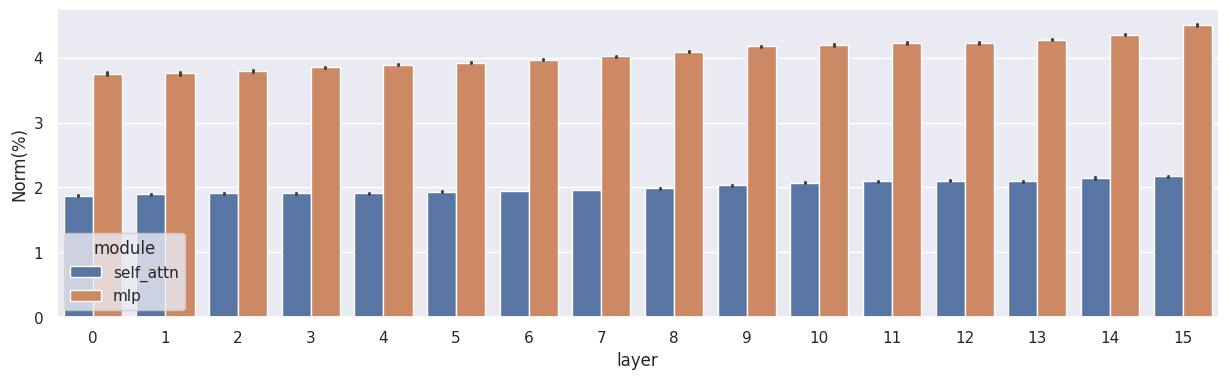

In [70]:
sns.set_theme(rc={'figure.figsize':(15,4)})
sns.barplot(x="layer", y="Norm(%)", hue="module", data=df, width=.8,)

In [21]:
save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/grad_analysis'

first_sh_norms = pd.DataFrame([io.load_json(f)["single_hop_efficacyq0_grad_norms"] for f in glob(f'{save_dir}/*.json', recursive=True)])
second_sh_norms = pd.DataFrame([io.load_json(f)["single_hop_efficacyq1_grad_norms"] for f in glob(f'{save_dir}/*.json', recursive=True)])
mh_norms = pd.DataFrame([io.load_json(f)["multi_hop_efficacyq0_grad_norms"] for f in glob(f'{save_dir}/*.json', recursive=True)])

In [22]:
save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/prepend_grad_analysis'

prepend_first_sh_norms = pd.DataFrame([io.load_json(f)["single_hop_efficacyq0_grad_norms"] for f in glob(f'{save_dir}/*.json', recursive=True)])
prepend_second_sh_norms = pd.DataFrame([io.load_json(f)["single_hop_efficacyq1_grad_norms"] for f in glob(f'{save_dir}/*.json', recursive=True)])
prepend_mh_norms = pd.DataFrame([io.load_json(f)["multi_hop_efficacyq0_grad_norms"] for f in glob(f'{save_dir}/*.json', recursive=True)])

In [26]:
non_transformer_block_ks = [k for k in grad_norms.keys() if "layers" not in k]

In [6]:
def show_norm_proportion(grad_norms):
    non_transformer_block_ks = [k for k in grad_norms.keys() if "layers" not in k]

    print("norm from non-transformer blocks:", round(sum(grad_norms[k] for k in non_transformer_block_ks) / sum(grad_norms.values()) * 100, 1), "%\n")

    print("Norm from transformer blocks:")
    mlp_or_attn_ks = [k for k in grad_norms.keys() if "layers" in k and ("mlp" in k or "self_attn" in k)]
    print("norm from mlp or attn:", round(sum(grad_norms[k] for k in mlp_or_attn_ks) / sum(grad_norms.values()) * 100, 1), "%")

    non_mlp_or_attn_ks = [k for k in grad_norms.keys() if "layers" in k and not ("mlp" in k or "self_attn" in k)]
    print("norm from neither mlp nor attn:", round(sum(grad_norms[k] for k in non_mlp_or_attn_ks) / sum(grad_norms.values()) * 100, 1), "%")

In [20]:
print("First Single-hop:")
show_norm_proportion(first_sh_norms.mean().to_dict())
print("====================================")
print("Second Single-hop:")
show_norm_proportion(second_sh_norms.mean().to_dict())
print("====================================")
print("Multi-hop:")
show_norm_proportion(mh_norms.mean().to_dict())

First Single-hop:
norm from non-transformer blocks: 2.7 %

Norm from transformer blocks:
norm from mlp or attn: 95.3 %
norm from neither mlp nor attn: 2.1 %
Second Single-hop:
norm from non-transformer blocks: 2.5 %

Norm from transformer blocks:
norm from mlp or attn: 95.5 %
norm from neither mlp nor attn: 2.0 %
Multi-hop:
norm from non-transformer blocks: 2.5 %

Norm from transformer blocks:
norm from mlp or attn: 95.5 %
norm from neither mlp nor attn: 2.0 %


In [33]:
from collections import defaultdict
# accumulate norms for each layer by mlp or self_attn
df_content = []

for has_ctx, question_type, grad_norms in [
    (False, "AtomQ_i", first_sh_norms), 
    (False, "AtomQ_j", second_sh_norms), 
    (False, "CompQ", mh_norms),
    (True, "AtomQ_i", prepend_first_sh_norms), 
    (True, "AtomQ_j", prepend_second_sh_norms), 
    (True, "CompQ", prepend_mh_norms),
]:
    for instance_norm in grad_norms.to_dict("records"):
        total_instance_norms = sum(instance_norm.values())
        norm_lookup = defaultdict(float)

        for k, v in instance_norm.items():
            
            if f"layers." in k:
                l = k.split(".")[2]
                assert l.isdigit()
                l = int(l)
                
                module = k.split(".")[3]
                if module in ["mlp", "self_attn"]:
                    norm_lookup[(l, module)] += v
                else:
                    continue
            else:
                assert k in non_transformer_block_ks
                continue
            
        norm_lookup = {k: v for k, v in norm_lookup.items()}
        

        for (l, module), percentage in norm_lookup.items():
            df_content.append({
                "layer": l,
                "module": module, 
                "Norm": percentage, 
                "Method": "CPT+prepend" if has_ctx else "CPT",
                "Question Type": question_type
            })
df = pd.DataFrame(df_content)

In [32]:
df

,layer,module,Norm,Method,Question Type
0,0,self_attn,26.772300,CPT,AtomQ_i
1,0,mlp,30.077084,CPT,AtomQ_i
2,1,self_attn,27.012958,CPT,AtomQ_i
3,1,mlp,101.839438,CPT,AtomQ_i
4,2,self_attn,19.189985,CPT,AtomQ_i
...,...,...,...,...,...
19195,13,mlp,35.912560,CPT+prepend,CompQ
19196,14,self_attn,28.955328,CPT+prepend,CompQ
19197,14,mlp,43.438254,CPT+prepend,CompQ
19198,15,self_attn,37.674881,CPT+prepend,CompQ


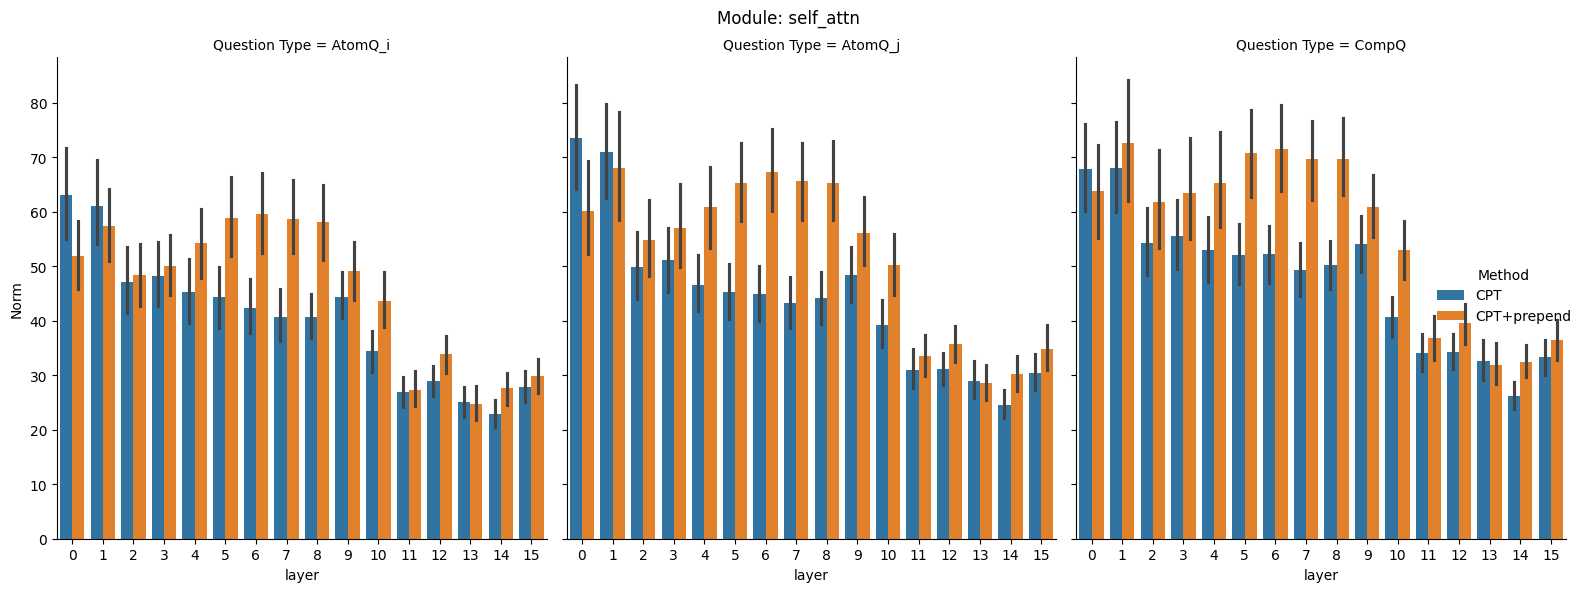

In [42]:
module = "self_attn"

sns.catplot(
    df[df["module"] == module], kind="bar",
    x="layer", y="Norm", hue="Method", col="Question Type", 
    height=6, aspect=.8,
)

plt.suptitle("Module: " + module)
plt.tight_layout()
plt.subplots_adjust(top=0.9)


# Linear interpolation hypothesis of AtomQ_i, AtomQ_j and CompQ

In [56]:
save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/grad_analysis'

interpolation_ts = pd.DataFrame([io.load_json(f)["interpolation_t"] for f in glob(f'{save_dir}/*.json', recursive=True)])

save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/prepend_grad_analysis'

prepend_interpolation_ts = pd.DataFrame([io.load_json(f)["interpolation_t"] for f in glob(f'{save_dir}/*.json', recursive=True)])

In [57]:
# pd.DataFrame([io.load_json('../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/prepend_grad_analysis/2hop__403712_793210_grad_info.json')["interpolation_t"]]).T

In [ ]:
from collections import defaultdict
# accumulate norms for each layer by mlp or self_attn
df_content = []

for method, ts in [("CPT", interpolation_ts), ("CPT+prepend", prepend_interpolation_ts)]:
    for instance_ts in ts.to_dict("records"):
        total_t_lookup = defaultdict(float)
        total_module_lookup = defaultdict(float)

        for k, v in instance_ts.items():
            
            if f"layers." in k:
                l = k.split(".")[2]
                assert l.isdigit()
                l = int(l)
                
                module = k.split(".")[3]
                if module in ["mlp", "self_attn"]:
                    total_t_lookup[(l, module)] += v
                    total_module_lookup[(l, module)] += 1
                else:
                    continue
            else:
                assert k in non_transformer_block_ks
                continue
            
        total_t_lookup = {k: v / total_module_lookup[k] for k, v in total_t_lookup.items()}
        

        for (l, module), avg_t in total_t_lookup.items():
            df_content.append({"layer": l, "module": module, "t": avg_t, "Method": method})
df = pd.DataFrame(df_content)

In [64]:
df

,layer,module,t,Method
0,0,self_attn,0.972000,CPT
1,0,mlp,0.993477,CPT
2,1,self_attn,0.987398,CPT
3,1,mlp,1.005097,CPT
4,2,self_attn,0.960137,CPT
...,...,...,...,...
6395,13,mlp,0.796759,CPT+prepend
6396,14,self_attn,0.886581,CPT+prepend
6397,14,mlp,0.908932,CPT+prepend
6398,15,self_attn,1.141144,CPT+prepend


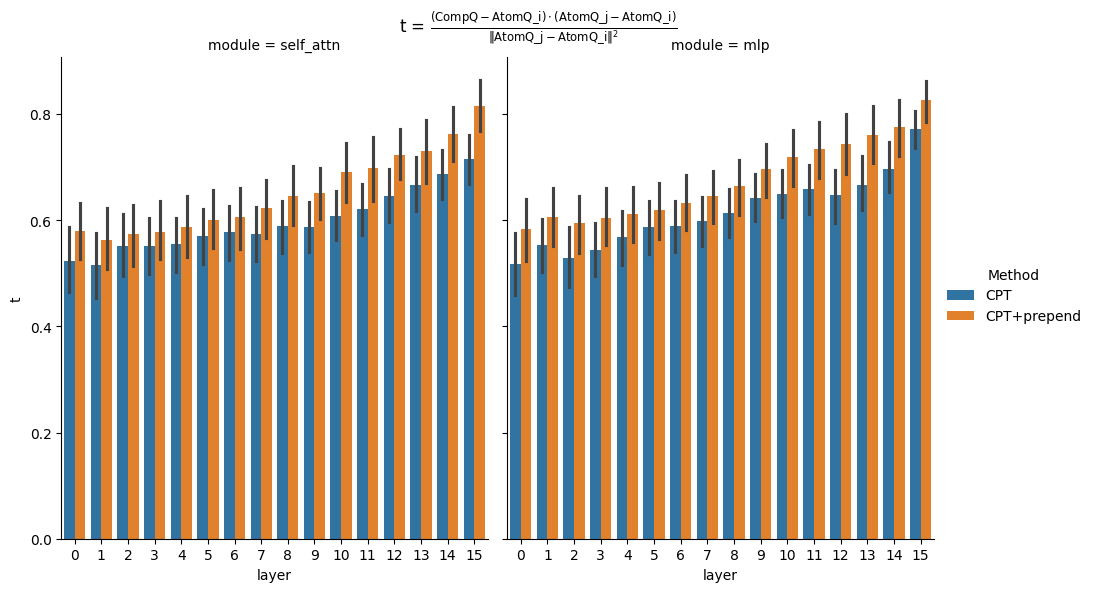

In [72]:

sns.catplot(
    df, kind="bar",
    x="layer", y="t", hue="Method", col="module", 
    height=6, aspect=.8,
)

plt.suptitle("t = $\\frac{(\\text{CompQ}-\\text{AtomQ_i})\\cdot (\\text{AtomQ_j}-\\text{AtomQ_i})}{\|\\text{AtomQ_j}-\\text{AtomQ_i}\|^2}$")
# plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [81]:
save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/grad_analysis'

interpolation_distances = pd.DataFrame([io.load_json(f)["distance_from_C_to_P"] for f in glob(f'{save_dir}/*.json', recursive=True)])

save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/prepend_grad_analysis'

prepend_interpolation_distances = pd.DataFrame([io.load_json(f)["distance_from_C_to_P"] for f in glob(f'{save_dir}/*.json', recursive=True)])

In [82]:
from collections import defaultdict
# accumulate norms for each layer by mlp or self_attn
df_content = []

for method, distances in [("CPT", interpolation_distances), ("CPT+prepend", prepend_interpolation_distances)]:
    for instance_distances in distances.to_dict("records"):
        total_distance_lookup = defaultdict(float)
        total_module_lookup = defaultdict(float)

        for k, v in instance_distances.items():
            
            if f"layers." in k:
                l = k.split(".")[2]
                assert l.isdigit()
                l = int(l)
                
                module = k.split(".")[3]
                if module in ["mlp", "self_attn"]:
                    total_distance_lookup[(l, module)] += v
                    total_module_lookup[(l, module)] += 1
                else:
                    continue
            else:
                assert k in non_transformer_block_ks
                continue
            
        total_distance_lookup = {k: v / total_module_lookup[k] for k, v in total_distance_lookup.items()}
        

        for (l, module), avg_distance in total_distance_lookup.items():
            df_content.append({"layer": l, "module": module, "distance": avg_distance, "Method": method})
df = pd.DataFrame(df_content)

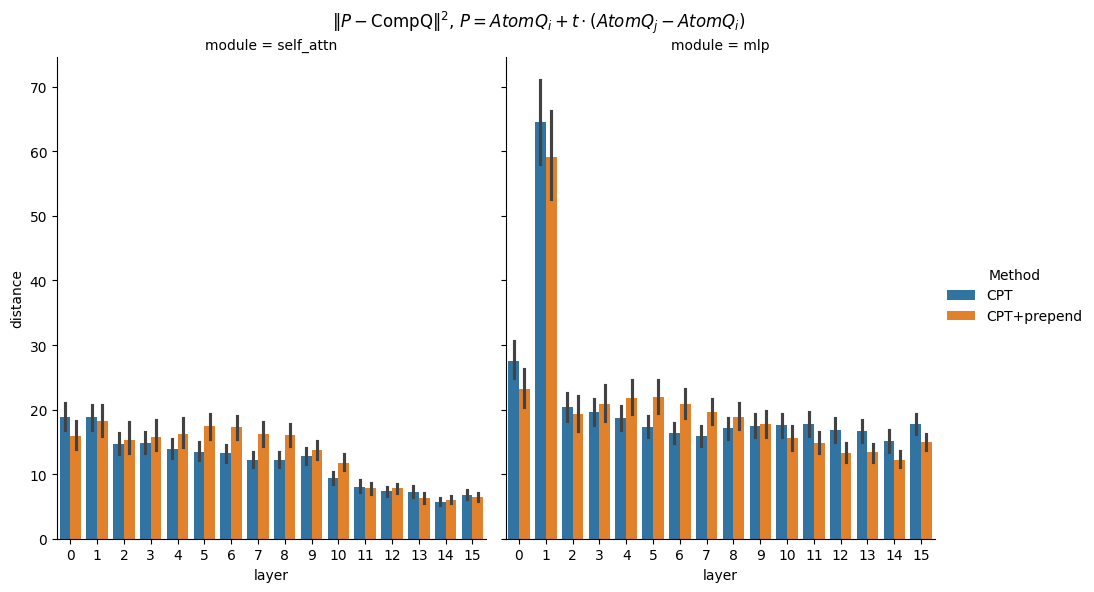

In [90]:

sns.catplot(
    df, kind="bar",
    x="layer", y="distance", hue="Method", col="module", 
    height=6, aspect=.8,
)

plt.suptitle("$\|P-\\text{CompQ}\|^2$, $P = AtomQ_i + t \\cdot (AtomQ_j - AtomQ_i)$")
# plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Measure changes in prob over gold answer.

In [94]:
save_dir = '../exp_output/Llama-3.2-1B-eos-sft_clm-baseline_input=two-1hop_lr=1e-05_epoch=4.0/prob_analysis'

probs = pd.DataFrame([ ])

In [103]:
# prob_info["prob"] = 


np.float64(0.8604232581882204)

In [116]:
df_content = []

for f in glob(f'{save_dir}/*.json', recursive=True):
    prob_infos = io.load_jsonlines(f)
    for prob_info in prob_infos:
        prob_info["prob"] = np.exp(np.array(prob_info["log_prob"])).sum() / prob_info["n_tokens"]
        df_content.append(prob_info)
df = pd.DataFrame(df_content)

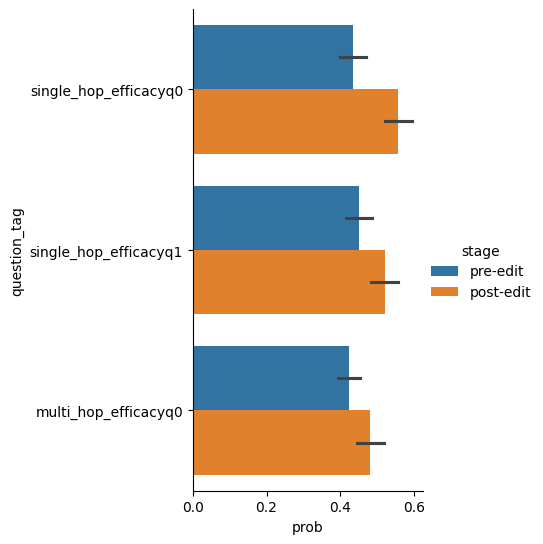

In [123]:

sns.catplot(
    df, kind="bar",
    y="question_tag", x="prob", hue="stage", 
    height=6, aspect=.8,
)

# plt.suptitle("$\|P-\\text{CompQ}\|^2$, $P = AtomQ_i + t \\cdot (AtomQ_j - AtomQ_i)$")
# plt.tight_layout()
plt.subplots_adjust(top=0.9)

,stage,question_tag,question_type,id,question,answer,answer_ids,n_tokens,log_prob,prob
0,pre-edit,single_hop_efficacyq0,single_hop_efficacy,2hop__700093_455653,What political party is dimuthu bandara abayak...,Janatha Vimukthi Peramuna,"[4448, 66826, 95584, 3178, 339, 72, 3700, 309,...",10.0,"[-4.753875255584717, -0.11346013098955154, -0....",0.860423
1,pre-edit,single_hop_efficacyq1,single_hop_efficacy,2hop__700093_455653,Who founded the janatha vimukthi peramuna?,Rohana Wijeweera,"[42087, 3444, 468, 3251, 88823, 2473, 128001]",7.0,"[-10.634397506713867, -4.649412155151367, -0.5...",0.620950
2,pre-edit,multi_hop_efficacyq0,multi_hop_efficacy,2hop__700093_455653,Who founded the political party of Dimuthu Ban...,Rohana Wijeweera,"[42087, 3444, 468, 3251, 88823, 2473, 128001]",7.0,"[-5.096766948699951, -1.615262508392334, -0.90...",0.590651
3,post-edit,single_hop_efficacyq0,single_hop_efficacy,2hop__700093_455653,What political party is dimuthu bandara abayak...,Janatha Vimukthi Peramuna,"[4448, 66826, 95584, 3178, 339, 72, 3700, 309,...",10.0,"[-0.03517025709152222, -0.0031355286482721567,...",0.908848
4,post-edit,single_hop_efficacyq1,single_hop_efficacy,2hop__700093_455653,Who founded the janatha vimukthi peramuna?,Rohana Wijeweera,"[42087, 3444, 468, 3251, 88823, 2473, 128001]",7.0,"[-0.9562824964523315, -5.602820692729438e-06, ...",0.808838
...,...,...,...,...,...,...,...,...,...,...
595,pre-edit,single_hop_efficacyq1,single_hop_efficacy,2hop__310456_846599,Who is the child of stefan nemanja?,Saint Sava,"[14539, 328, 2979, 128001]",4.0,"[-8.868598937988281, -1.8114876747131348, -0.3...",0.465060
596,pre-edit,multi_hop_efficacyq0,multi_hop_efficacy,2hop__310456_846599,Who is the child of the person who followed Ti...,Saint Sava,"[14539, 328, 2979, 128001]",4.0,"[-5.329869270324707, -2.2794570922851562, -0.2...",0.459221
597,post-edit,single_hop_efficacyq0,single_hop_efficacy,2hop__310456_846599,Who followed tihomir of serbia according to th...,Stefan Nemanja,"[50002, 452, 16357, 5697, 128001]",5.0,"[-1.9743249416351318, -0.13055485486984253, -4...",0.602852
598,post-edit,single_hop_efficacyq1,single_hop_efficacy,2hop__310456_846599,Who is the child of stefan nemanja?,Saint Sava,"[14539, 328, 2979, 128001]",4.0,"[-9.577922821044922, -3.4992010593414307, -0.0...",0.396083
